In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '../')

# Data Processing: garbage in, treasure out

In [3]:
import torch
import feather
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from scipy import ndimage

from modules.util.util import find_borders
from modules.util.gaussian_smoothing import GaussianSmoothing

In [4]:
df_meta = pd.read_feather('../metadata/df_meta.fth')
df_meta_trn = df_meta[df_meta.is_valid==False]

Turns out using only lesion ares for training makes it tough for our model to learn. We are going to be sampling from all of our data to increase the size of our training dataset. To achieve this we will do the following steps to each CT:
1. Create a bounding box around the 'human' part of the scan to weed out the empty space
2. Sample from this bounding box by returning uniformly spaced out coordinates

Grabbing the human part involves these steps:
1. apply gaussian blur on the volume
2. create a mask based on voxels surpassing a brightness threshold
3. create a bounding box around the mask

Load the volume

In [5]:
sample_ct_fname = df_meta_trn.ct_fname.iloc[0]
ct_a = nib.load(sample_ct_fname).get_fdata()
ct_t = torch.from_numpy(ct_a.T.astype(np.float32))

Apply gaussian blur

In [71]:
gaussian_blur = GaussianSmoothing(channels=ct_t.shape[0], kernel_size=3, sigma=3)
x = ct_t[None]
x_pad = F.pad(x, (1,1,1,1), mode='reflect')
x_blur = gaussian_blur(x_pad)

In [72]:
img = x.squeeze()[35:36].squeeze()
img_blur = x_blur.squeeze()[35:36].squeeze()

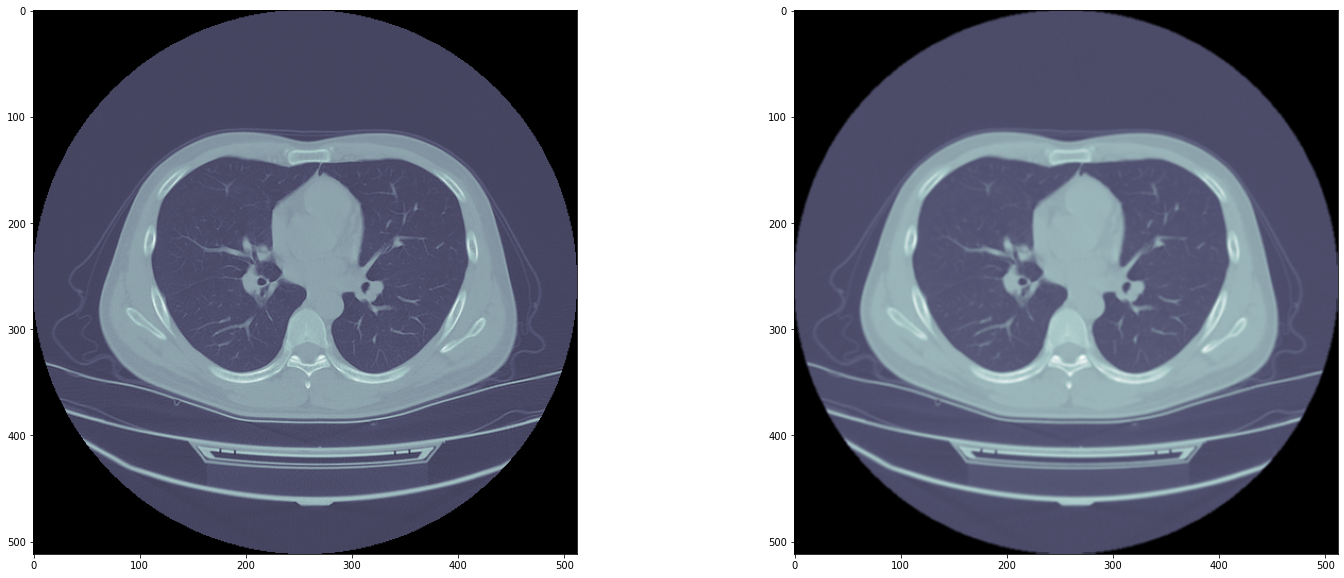

In [73]:
fig, ax = plt.subplots(1,2, figsize=(25,10))
ax[0].imshow(img, cmap="bone")
ax[1].imshow(img_blur, cmap="bone")

In [41]:
# normalize
x_blur.clamp(-1000,1000)
x_blur /= 2000
x_blur += .5

Create voxel mask based on threshold

In [42]:
x_mask = (x_blur > .2).float()
x_mask = torch.tensor(ndimage.binary_erosion(x_mask.numpy(), structure=np.ones((1,5,5,5)))).float()
x_masked = x * x_mask

Now lets plot it to see the results

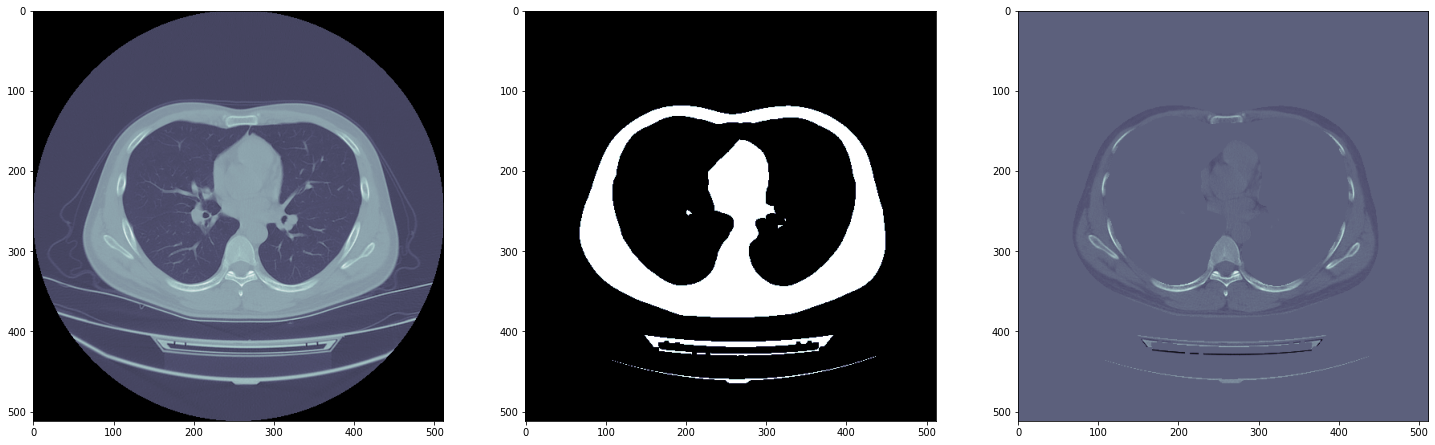

In [43]:
orig_samp = torch.squeeze(ct_t[35:36])
mask_samp = torch.squeeze(x_mask[:,35:36])
blur_samp = torch.squeeze(x_masked[:,35:36])
fig, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].imshow(orig_samp, cmap="bone")
ax[1].imshow(mask_samp, cmap="bone")
ax[2].imshow(blur_samp, cmap="bone")

Great our mask is working well. All that is left is to filter out the blank space by cropping a box around the mask.

We grab the border in each axis by squishing the sides until a threshold of pixels is reached.

In [9]:
lo_i, hi_i = find_borders(torch.squeeze(x_mask.sum(axis=(-2,-1))), thresh=40000)
lo_r, hi_r = find_borders(torch.squeeze(x_mask.sum(axis=(-3,-1))), thresh=6000)
lo_c, hi_c = find_borders(torch.squeeze(x_mask.sum(axis=(-3,-2))), thresh=6000)
(lo_i,hi_i),(lo_r,hi_r),(lo_c,hi_c)

((2, 67), (123, 379), (82, 438))

Now that we have the border coordinates, we can clip our the human part

In [10]:
ct_clip = ct_t[lo_i:hi_i,lo_r:hi_r,lo_c:hi_c]

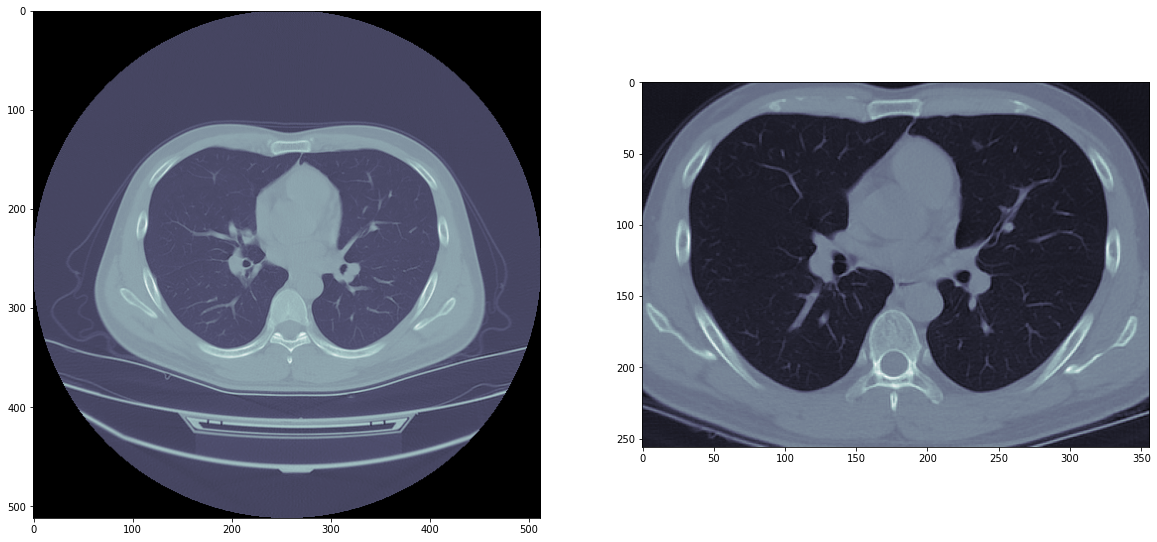

In [11]:
ct_clip_samp = torch.squeeze(ct_clip[35:36])
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(orig_samp, cmap="bone")
ax[1].imshow(ct_clip_samp, cmap="bone")

All thats left to do is to sample uniformly between the output borders to get random coordinates

In [5]:
def uniform_sample(low, high, n_samples=10):
    x = low
    step = ((high - low) // n_samples)
    samples = []
    while x < high:
        x += step
        if x < high:
            samples.append(x)
    return samples

In [13]:
idx_coords = uniform_sample(lo_i, hi_i)
row_coords = uniform_sample(lo_r, hi_r)
col_coords = uniform_sample(lo_c, hi_c)

Now to generate irc coordinates, we need to pair them up in O(i\*r\*c) time

In [14]:
center_coordinates = []
for i in idx_coords:
    for r in row_coords:
        for c in col_coords:
            center_coordinates.append((i,r,c))
len(center_coordinates)

1000

Wow! 1000 new datapoints from just one ct

Lets wrap those steps up in a ready to go function

In [9]:
def get_human_part(ct, lesion_mask, thresh=.2):
    gaussian_blur = GaussianSmoothing(channels=ct.shape[0], kernel_size=3, sigma=3)
    x = ct_t[None]
    x_pad = F.pad(x, (1,1,1,1), mode='reflect')
    x_blur = gaussian_blur(x_pad.clamp(-1000,1000))
    x_blur /= 2000
    x_blur += .5
    x_mask = (x_blur > thresh).float()
    x_mask = torch.tensor(ndimage.binary_erosion(x_mask.numpy(), structure=np.ones((1,5,5,5)))).float()
    i_thresh = 50000
    lo_i = hi_i = 0
    while (hi_i - lo_i) < int(ct.shape[0] * .9):
        lo_i, hi_i = find_borders(torch.squeeze(x_mask.sum(axis=(-2,-1))), thresh=i_thresh)
        i_thresh -= 10000
    lo_r, hi_r = find_borders(torch.squeeze(x_mask.sum(axis=(-3,-1))), thresh=6000)
    lo_c, hi_c = find_borders(torch.squeeze(x_mask.sum(axis=(-3,-2))), thresh=6000)
    idx_coords = uniform_sample(lo_i, hi_i)
    row_coords = uniform_sample(lo_r, hi_r)
    col_coords = uniform_sample(lo_c, hi_c)
    center_coordinates = [[],[],[]]
    for i in idx_coords:
        for r in row_coords:
            for c in col_coords:
                center_coordinates[0].append(i)
                center_coordinates[1].append(r)
                center_coordinates[2].append(c)
    return ct_t[lo_i:hi_i,lo_r:hi_r,lo_c:hi_c], center_coordinates

1000


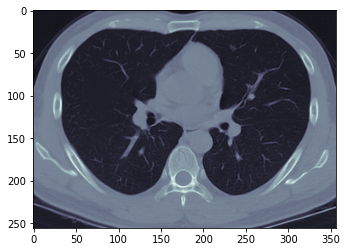

In [16]:
ct_clip, center_coords = get_human_part(ct_t)
print(len(center_coords[0]))
plt.imshow(torch.squeeze(ct_clip[35:36]), cmap="bone")

Finally, we can iterate through each CT scan and save the uniformly sampled coordinates

In [7]:
uid_list = []
idx_list = []
row_list = []
col_list = []

In [10]:
for _, row in tqdm(df_meta_trn.iterrows(), total=len(df_meta_trn)):
    ct_a = nib.load(row.ct_fname).get_fdata()
    ct_t = torch.from_numpy(ct_a.T.astype(np.float32))
    _, [i_list, r_list, c_list] = get_human_part(ct_t)
    uid_list += [row.uid] * len(i_list)
    idx_list += i_list
    row_list += r_list
    col_list += c_list

100%|██████████| 199/199 [04:52<00:00,  1.47s/it]


In [12]:
df_random_coords = pd.DataFrame({'uid': uid_list, 'coordI': idx_list, 'coordR': row_list, 'coordC': col_list})
# df_random_coords.to_feather('../metadata/df_random_coords.fth')